In [1]:
import os
import os.path
import time
import numpy as np
import tensorflow as tf
import cv2
import sys
import random
import functools
from tqdm import tqdm
from pathlib import Path
from skimage.measure import compare_ssim
import matplotlib.pyplot as plt

import predrnn_pp
import dataset_utils
from nets import models_factory
from data_provider import datasets_factory
from utils import preprocess
from utils import metrics

In [11]:
sys.path.append('../../../')

In [13]:
from modis_utils.misc import cache_data, restore_data

In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [15]:
data_dir = '../one_output/data_patch'
model_name = 'predrnn_pp'
save_dir = 'results/predrnn_pp'
input_length = 14
output_length = 1
img_width = 32
img_channel = 1
stride = 1
filter_size = 5
num_hidden = [128, 64, 64, 1]
num_layers = len(num_hidden)
patch_size = 4
layer_norm = True
lr = 0.001
reverse_input = False
batch_size = 8
max_iterations = 80000
display_interval = 1
test_interval = 2000
snapshot_interval = 10000

save_checkpoints_steps = 100

In [16]:
params = {
    "data_dir" : data_dir,
    "model_name" :  model_name,
    "save_dir" : save_dir,
    "input_length" : input_length,
    "output_length" : output_length,
    "seq_length" : input_length + output_length,
    "img_width" : img_width,
    "img_channel" : img_channel,
    "stride" : stride,
    "filter_size" : filter_size,
    "num_hidden" : num_hidden,
    "num_layers" : num_layers,
    "patch_size" : patch_size,
    "layer_norm" : layer_norm,
    "lr" : lr,
    "reverse_input" : reverse_input,
    "batch_size" : batch_size,
    "max_iterations" : max_iterations,
    "display_interval" : display_interval,
    "test_interval" : test_interval,
    "snapshot_interval" : snapshot_interval
}

In [17]:
def model_fn(features, labels, mode, params):
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    predictions = predrnn_pp.rnn(features, params["num_layers"], params["num_hidden"], params["filter_size"],
                                 params["stride"], params["seq_length"], params["input_length"], 
                                 params["layer_norm"])
    predictions = predictions[:, params["input_length"]-1:]
    print("predictions.shape =", predictions.shape)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    else:
        loss = tf.losses.mean_squared_error(labels=labels, predictions=predictions)
        tensors_to_log = {'loss': loss}
        logging_hook = tf.train.LoggingTensorHook(
            tensors=tensors_to_log, every_n_iter=100)
        train_hooks = [logging_hook]
        
        metrics = {
            'mse': tf.metrics.mean_squared_error(labels=labels, predictions=predictions)
        }

        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

        elif mode == tf.estimator.ModeKeys.TRAIN:
            train_op = tf.train.AdamOptimizer(learning_rate=params["lr"])\
                .minimize(loss, global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
        else:
            raise NotImplementedError()

In [18]:
def input_fn(data_dir, subset, batch_size,
             use_distortion_for_training=True):
    use_distortion = subset == 'train' and use_distortion_for_training
    dataset = dataset_utils.ConvLSTMDataSet(data_dir, subset, use_distortion)
    return dataset.make_batch(batch_size)

In [19]:
test_inpf = functools.partial(input_fn, data_dir, 'test', batch_size)
val_inpf = functools.partial(input_fn, data_dir, 'val', batch_size)
train_inpf = functools.partial(input_fn, data_dir, 'train', batch_size)

cfg = tf.estimator.RunConfig(save_checkpoints_steps=save_checkpoints_steps)
estimator = tf.estimator.Estimator(model_fn, save_dir, cfg, params)

tf.logging.set_verbosity(tf.logging.INFO)

INFO:tensorflow:Using config: {'_model_dir': 'results/predrnn_pp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f36b42a50f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [21]:
result_test = estimator.evaluate(test_inpf,
    steps=dataset_utils.ConvLSTMDataSet.num_examples_per_epoch('test')//batch_size)

INFO:tensorflow:Calling model_fn.
predictions.shape = (8, 1, 32, 32, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-28-09:31:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/predrnn_pp/model.ckpt-21300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [17/172]
INFO:tensorflow:Evaluation [34/172]
INFO:tensorflow:Evaluation [51/172]
INFO:tensorflow:Evaluation [68/172]
INFO:tensorflow:Evaluation [85/172]
INFO:tensorflow:Evaluation [102/172]
INFO:tensorflow:Evaluation [119/172]
INFO:tensorflow:Evaluation [136/172]
INFO:tensorflow:Evaluation [153/172]
INFO:tensorflow:Evaluation [170/172]
INFO:tensorflow:Evaluation [172/172]
INFO:tensorflow:Finished evaluation at 2019-05-28-09:32:54
INFO:tensorflow:Saving dict for global step 21300: global_step = 21300, loss = 0.012188795, mse = 0.012188795
INFO:tensorflow:Saving 'checkpoint_path' summary for global s

In [22]:
result_test

{'loss': 0.012188795, 'mse': 0.012188795, 'global_step': 21300}

In [23]:
results = estimator.predict(test_inpf)
inferences = []
i = 0
for result in results:
    if i % 100 == 0:
        print(i)
    inferences.append(result)
    i += 1
    if i == dataset_utils.ConvLSTMDataSet.num_examples_per_epoch('test'):
        break

INFO:tensorflow:Calling model_fn.
predictions.shape = (8, 1, 32, 32, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/predrnn_pp/model.ckpt-21300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700


In [24]:
inferences = np.vstack(inferences)

In [33]:
if not os.path.exists('inferences'):
    os.makedirs('inferences')
cache_data(inferences, 'inferences/test.dat')

In [85]:
a = restore_data('inferences/test.dat')
a.shape

(2786, 32, 32, 1)

In [25]:
result_val = estimator.evaluate(val_inpf,
    steps=dataset_utils.ConvLSTMDataSet.num_examples_per_epoch('val')//batch_size)
result_val

INFO:tensorflow:Calling model_fn.
predictions.shape = (8, 1, 32, 32, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-28-09:35:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/predrnn_pp/model.ckpt-21300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [17/172]
INFO:tensorflow:Evaluation [34/172]
INFO:tensorflow:Evaluation [51/172]
INFO:tensorflow:Evaluation [68/172]
INFO:tensorflow:Evaluation [85/172]
INFO:tensorflow:Evaluation [102/172]
INFO:tensorflow:Evaluation [119/172]
INFO:tensorflow:Evaluation [136/172]
INFO:tensorflow:Evaluation [153/172]
INFO:tensorflow:Evaluation [170/172]
INFO:tensorflow:Evaluation [172/172]
INFO:tensorflow:Finished evaluation at 2019-05-28-09:36:45
INFO:tensorflow:Saving dict for global step 21300: global_step = 21300, loss = 0.009067808, mse = 0.009067808
INFO:tensorflow:Saving 'checkpoint_path' summary for global s

{'loss': 0.009067808, 'mse': 0.009067808, 'global_step': 21300}

In [26]:
result_train = estimator.evaluate(train_inpf,
    steps=dataset_utils.ConvLSTMDataSet.num_examples_per_epoch('train')//batch_size)
result_train

shuffle dataset
INFO:tensorflow:Calling model_fn.
predictions.shape = (8, 1, 32, 32, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-28-09:36:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/predrnn_pp/model.ckpt-21300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [201/2012]
INFO:tensorflow:Evaluation [402/2012]
INFO:tensorflow:Evaluation [603/2012]
INFO:tensorflow:Evaluation [804/2012]
INFO:tensorflow:Evaluation [1005/2012]
INFO:tensorflow:Evaluation [1206/2012]
INFO:tensorflow:Evaluation [1407/2012]
INFO:tensorflow:Evaluation [1608/2012]
INFO:tensorflow:Evaluation [1809/2012]
INFO:tensorflow:Evaluation [2010/2012]
INFO:tensorflow:Evaluation [2012/2012]
INFO:tensorflow:Finished evaluation at 2019-05-28-09:49:47
INFO:tensorflow:Saving dict for global step 21300: global_step = 21300, loss = 0.010196711, mse = 0.010196711
INFO:tensorflow:Saving

{'loss': 0.010196711, 'mse': 0.010196711, 'global_step': 21300}

In [27]:
a = inferences[0]

In [28]:
len(inferences)

2786

In [29]:
a.shape

(32, 32, 1)

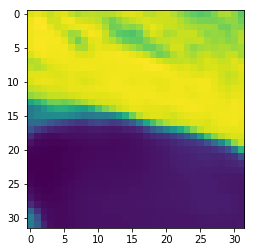

In [30]:
plt.imshow(a.squeeze())

In [34]:
sample_test_path = '../one_output/sequence_patch_data/test/0.dat'
sample_test = restore_data(sample_test_path)
sample_inputs = sample_test[0]
sample_labels = sample_test[1]
sample_inputs.shape, sample_labels.shape

((30, 14, 32, 32), (30, 1, 32, 32))

In [76]:
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def convert_to_tfrecord(inputs):
    r = np.random.randint(1000000)
    path = '.{}'.format(r)
    with tf.python_io.TFRecordWriter(path) as record_writer:
        num_entries_in_batch = len(inputs)
        for i in range(num_entries_in_batch):
            example = tf.train.Example(features=tf.train.Features(
                feature={
                    'inputs': _float_feature(inputs[i].flatten().tolist()),
                }))
            record_writer.write(example.SerializeToString())
    return path
        
def parser(serialized_example, single_example_shape):
    features = tf.parse_single_example(
        serialized_example,
        features={
            'inputs': tf.FixedLenFeature(
                [single_example_shape[0] * single_example_shape[1] * single_example_shape[2]],
                tf.float32),
        })
    inputs = tf.reshape(features['inputs'], single_example_shape)
    return inputs

In [82]:
def inference_from_np_array(estimator, inputs_np):
    tfrecord_path = convert_to_tfrecord(inputs_np)
    shape = inputs_np.shape
    single_example_shape = shape[1:] + (1,)
    def np_input_fn():
        dataset = tf.data.TFRecordDataset(tfrecord_path)
        dataset = dataset.map(
            functools.partial(
                parser, 
                single_example_shape=single_example_shape))
        dataset = dataset.batch(1, drop_remainder=True)
        iterator = dataset.make_one_shot_iterator()
        inputs = iterator.get_next()
        return inputs
    
    result = estimator.predict(np_input_fn)
    res1 = []
    for res in result:
        res1.append(res)
    os.remove(tfrecord_path)
    return np.vstack(res1).squeeze()

In [83]:
res = inference_from_np_array(estimator, sample_inputs)

INFO:tensorflow:Calling model_fn.
predictions.shape = (1, 1, 32, 32, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/predrnn_pp/model.ckpt-21300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [84]:
res.shape

(30, 32, 32)